#### Question 1
+ Formulate the Lagrangian function and give its partial derivatives. No further derivation required.

$$
L(w,\lambda,\gamma) = \frac{1}{2}w'\Sigma w + \lambda(m-w'\mu) + \gamma(1-w'1)
$$

$$
\begin{aligned}
\frac{\partial L}{\partial w}(w,\lambda,\gamma)& = \Sigma w - \lambda \mu - \gamma1= 0 \\
\frac{\partial L}{\partial \lambda}(w,\lambda,\gamma)& = 1 - w'1 = 0
\end{aligned}
$$

$$
w^* = \Sigma^{-1}(\lambda\mu + \gamma 1)
$$

+ Compute the allocations $w^*$ and portfolio risk $\sigma_\pi = \sqrt{\omega'\sum\omega}$, for m = 4.5%.
Now, stress the correlation matrix: multiply all correlations by x1.25 and x1.5, and compute the
respective optimal allocations and portfolio risk (the same m = 4.5%).

In [2]:
def get_porforlio_weights(mu, sigma, R, m):

    I = np.array([[1], [1], [1], [1]])
    S = np.diag(sigma.flatten())

    cov = S @ R @ S
    inv_cov = np.linalg.inv(cov)

    A = I.T @ inv_cov @ I
    B = I.T @ inv_cov @ mu
    C = mu.T @ inv_cov @ mu

    lamb = ((A * m - B) / (A * C - B * B))[0][0]
    gamma = ((C - B * m) / (A * C - B * B))[0][0]

    weights = inv_cov @ (lamb * mu + gamma * I)
    sigma_pi = np.sqrt(weights.T @ cov @ weights)

    return weights, sigma_pi

In [3]:
import numpy as np

mu = np.array([
        [0.02], 
        [0.07], 
        [0.15], 
        [0.20],
    ])

sigma = np.array([
        [0.05], 
        [0.12], 
        [0.17], 
        [0.25],
    ])

m = 0.045

R = np.array([   
        [1, 0.3, 0.3, 0.3], 
        [0.3, 1, 0.6, 0.6], 
        [0.3, 0.6, 1, 0.6], 
        [0.3, 0.6, 0.6, 1]
    ])

In [4]:
weights, sigma_pi = get_porforlio_weights(mu, sigma, R, m)

print(weights)
print(sigma_pi)

[[0.78511066]
 [0.05386419]
 [0.13355472]
 [0.02747042]]
[[0.05840091]]


In [5]:
def multiply_correlations(R, ratio):
    R_new = R.copy()
    for row_idx, row in enumerate(R):
        for col_idx, element in enumerate(row):
            if element == 1:
                R_new[row_idx][col_idx] = element
            else:
                R_new[row_idx][col_idx] = element * ratio
    return R_new

In [6]:
weights, sigma_pi = get_porforlio_weights(mu, sigma, multiply_correlations(R, 1.25), m)

print(weights)
print(sigma_pi)

[[ 0.81818944]
 [-0.00940302]
 [ 0.17896585]
 [ 0.01224773]]
[[0.0607102]]


In [7]:
weights, sigma_pi = get_porforlio_weights(mu, sigma, multiply_correlations(R, 1.5), m)

print(weights)
print(sigma_pi)

[[ 0.87617647]
 [-0.14612952]
 [ 0.32570145]
 [-0.0557484 ]]
[[0.06109091]]


+ Inverse optimisation: generate > 2,000 random allocations sets $w'$ - these will not be optimal allocations. Plot the cloud of points of $\mu_\pi$ vertically on $\sigma_\pi$ horizontally. Before computing $\mu_\pi$, $\sigma_\pi$, you can standardise to satisfy $w'1 = 1$.

In [8]:
from numpy import *
from numpy.linalg import multi_dot
import pandas as pd
from drs import drs

numofportfolio = 5000
numofasset = 4
newaxis = None

def get_random_ex(n, sum, lower, upper):
    l = [lower] * n
    u = [upper] * n
    numbers = drs(n, sum, u, l)
    return array(numbers)

def portfolio_simulation(mu, sigma, R):

    S = np.diag(sigma.flatten())
    cov = S @ R @ S

    # Initialize the lists
    rets = []; vols = []; wts = []

    # Simulate 5,000 portfolios
    for i in range (numofportfolio):
        
        # Generate random weights
        weights = get_random_ex(numofasset, 1, -1, 1)[:, newaxis]
        
        # Portfolio statistics
        rets.append(weights.T @ array(mu))        
        vols.append(sqrt(multi_dot([weights.T, cov, weights])))
        wts.append(weights.flatten())

    # Create a dataframe for analysis
    portdf = 100*pd.DataFrame({
        'port_rets': array(rets).flatten(),
        'port_vols': array(vols).flatten(),
        'weights': list(array(wts))
        })
    
    portdf['sharpe_ratio'] = portdf['port_rets'] / portdf['port_vols']

    return round(portdf,2)

In [9]:
temp = portfolio_simulation(mu, sigma, R)
temp

,port_rets,port_vols,weights,sharpe_ratio
0,-1.08,11.52,"[69.03492387622161, 94.93063840962887, -73.729...",-0.09
1,9.82,12.66,"[94.82918435926102, -79.65877138944566, 69.264...",0.78
2,24.06,27.92,"[-78.69131484510199, 60.657223497223754, 44.32...",0.86
3,19.01,21.33,"[-17.328221921261832, 17.57936355041072, 36.40...",0.89
4,3.70,13.30,"[49.08483376614128, 83.95424699671668, -68.933...",0.28
...,...,...,...,...
4995,10.31,23.26,"[21.9562055796364, 81.1595508583397, -96.29947...",0.44
4996,18.11,19.98,"[46.895145787755375, -78.87121295442039, 74.06...",0.91
4997,12.57,14.40,"[54.71681992689135, -26.50082914842735, 20.440...",0.87
4998,8.74,16.29,"[99.19945287138994, -34.520154853366705, -42.1...",0.54


In [10]:
# Import plotly express for EF plot
import plotly.express as px
px.defaults.template = "plotly_dark"
px.defaults.width = 1000
px.defaults.height = 600

# Plot simulated portfolio
fig = px.scatter(
    temp, x='port_vols', y='port_rets', color='sharpe_ratio', 
    labels={'port_vols': 'Expected Volatility', 'port_rets': 'Expected Return','sharpe_ratio': 'Sharpe Ratio'},
    title="Monte Carlo Simulated Portfolio"
     ).update_traces(mode='markers', marker=dict(symbol='cross'))

# Plot max sharpe 
fig.add_scatter(
    mode='markers', 
    x=[temp.iloc[temp.sharpe_ratio.idxmax()]['port_vols']], 
    y=[temp.iloc[temp.sharpe_ratio.idxmax()]['port_rets']], 
    marker=dict(color='RoyalBlue', size=20, symbol='star'),
    name = 'Max Sharpe'
).update(layout_showlegend=False)

# Show spikes
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.show()

#### Question 2

+ Formulate the Lagrangian function and give its partial derivatives only.

$$
L(w,\lambda) = \frac{1}{2}w'\Sigma w + \lambda(m - r - w'(\mu - r1))
$$

$$
\frac{\partial L}{\partial w}(w,\lambda) = \Sigma w - \lambda (\mu - r1) = 0
$$

$$
w^* = \lambda \Sigma^{-1}(\mu - r1)
$$


+ For the range of tangency portfolios given by $r_f = 50bps, 100bps, 150bps, 175bps$ optimal compute allocations (ready formula) and $\sigma_\pi$. Present results in a table.

In [11]:
def get_tangency_porforlio_weights(mu, sigma, R, r):

    I = np.array([[1], [1], [1], [1]])
    S = np.diag(sigma.flatten())

    cov = S @ R @ S
    inv_cov = np.linalg.inv(cov)

    A = I.T @ inv_cov @ I
    B = I.T @ inv_cov @ mu
    C = mu.T @ inv_cov @ mu

    weights = inv_cov @ (mu - r * I) / (B - A * r)
    m_t = weights.T @ mu
    sigma_t = np.sqrt(weights.T @ cov @ weights)

    return weights, m_t, sigma_t

In [12]:
from tabulate import tabulate

mu = np.array([
        [0.02], 
        [0.07], 
        [0.15], 
        [0.20],
    ])

sigma = np.array([
        [0.05], 
        [0.12], 
        [0.17], 
        [0.25],
    ])

R = np.array([   
        [1, 0.3, 0.3, 0.3], 
        [0.3, 1, 0.6, 0.6], 
        [0.3, 0.6, 1, 0.6], 
        [0.3, 0.6, 0.6, 1]
    ])

rf_50 = 0.005
rf_100 = 0.01
rf_150 = 0.015
rf_175 = 0.0175

weights_50, m_50, sigma_50 = get_tangency_porforlio_weights(mu, sigma, R, rf_50)
weights_100, m_100, sigma_100 = get_tangency_porforlio_weights(mu, sigma, R, rf_100)
weights_150, m_150, sigma_150 = get_tangency_porforlio_weights(mu, sigma, R, rf_150)
weights_175, m_175, sigma_175 = get_tangency_porforlio_weights(mu, sigma, R, rf_175)

table = [
            ['50', m_50[0][0], sigma_50[0][0], weights_50.flatten()],
            ['100', m_100[0][0], sigma_100[0][0], weights_100.flatten()],
            ['150', m_150[0][0], sigma_150[0][0], weights_150.flatten()],
            ['175', m_175[0][0], sigma_175[0][0], weights_175.flatten()]
        ]
header = ['bps', 'mean', 'sigma', 'weights']
print(tabulate(table, headers=header, tablefmt='grid'))

+-------+----------+----------+---------------------------------------------------+
|   bps |     mean |    sigma | weights                                           |
+=======+==========+==========+===================================================+
|    50 |  0.18607 | 0.196511 | [ 0.0168352  -0.22936698  0.81434026  0.39819152] |
+-------+----------+----------+---------------------------------------------------+
|   100 |  0.32613 | 0.350665 | [-0.74593711 -0.51056937  1.49024934  0.76625714] |
+-------+----------+----------+---------------------------------------------------+
|   150 |  1.77653 | 1.97239  | [-8.64485405 -3.42257114  8.48965087  4.57777433] |
+-------+----------+----------+---------------------------------------------------+
|   175 | -1.2988  | 1.47351  | [ 8.10350247  2.75185052 -6.3514309  -3.50392209] |
+-------+----------+----------+---------------------------------------------------+


+ Plot the true Effcient Frontier in the presence of risk-free earning asset for $r_f = 100bps, 175bps$ and specifically identify its shape.

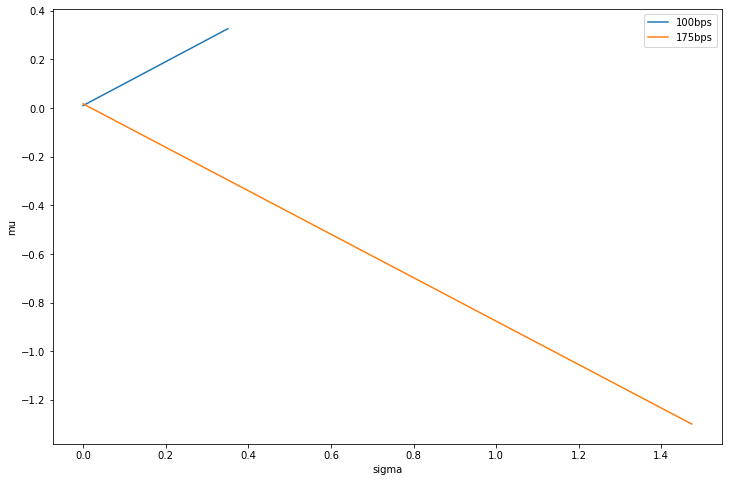

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.xlabel('sigma')
plt.ylabel('mu')

plt.plot([0, sigma_100[0][0]], [rf_100, m_100[0][0]], label='100bps')
plt.plot([0, sigma_175[0][0]], [rf_175, m_175[0][0]], label='175bps')

plt.legend(loc='upper right', frameon=True)

plt.show()


#### Question 3
Pls see the excel file.

#### Question 4

In [43]:
from tabulate import tabulate

portfolio_value = 16
mu = 0.01
sigma = 0.03
mu_spread = 0.0035
sigma_spread = 0.015
factor = 2.326

VaR = portfolio_value * (-mu + factor * sigma)
Liquidity = portfolio_value * (1/2 * (mu_spread + factor * sigma_spread))
LVaR = VaR + Liquidity

table = [
            [LVaR, VaR, VaR/LVaR, Liquidity, Liquidity/LVaR],
        ]
header = ['LVaR(million $)', 'VaR(million $)', 'VaR proportion', 'Liquidity', 'Liquidity proportion']

print(tabulate(table, headers=header, tablefmt="grid", floatfmt='0.4f'))


+-------------------+------------------+------------------+-------------+------------------------+
|   LVaR(million $) |   VaR(million $) |   VaR proportion |   Liquidity |   Liquidity proportion |
+===================+==================+==================+=============+========================+
|            1.2636 |           0.9565 |           0.7569 |      0.3071 |                 0.2431 |
+-------------------+------------------+------------------+-------------+------------------------+


In [44]:
# https://www.investopedia.com/articles/trading/11/understanding-liquidity-risk.asp

# Liquidity-adjusted VaR (LVaR) = position ($) * [-drift (%) + volatility * deviate + 0.5 * spread]

portfolio_value = 40
mu = 0
sigma = 0.03
spread_1 = 0.0015
spread_2 = 0.0125
factor = 2.326

VaR = portfolio_value * (-mu + factor * sigma)
Liquidity_1 = portfolio_value * (1/2 * spread_1)
LVaR_1 = VaR + Liquidity_1
Liquidity_2 = portfolio_value * (1/2 * spread_2)
LVaR_2 = VaR + Liquidity_2

table = [
            ['15 bps', LVaR_1, VaR, VaR/LVaR_1, Liquidity_1, Liquidity_1/LVaR_1],
            ['125 bps', LVaR_2, VaR, VaR/LVaR_2, Liquidity_2, Liquidity_2/LVaR_2],
        ]
header = ['bid-ask spread', 'LVaR(million $)', 'VaR(million $)', 'VaR proportion', 'Liquidity', 'Liquidity proportion']

print(tabulate(table, headers=header, tablefmt="grid", floatfmt='0.4f'))

print(f'if the bid-ask spread increases to 125 bps, the VaR remains unchanged, and the Liquidity increases greatly from {Liquidity_1:.4f} to {Liquidity_2:.4f}, which increases the LVaR from {LVaR_1:.4f} to {LVaR_2:.4f}.')

+------------------+-------------------+------------------+------------------+-------------+------------------------+
| bid-ask spread   |   LVaR(million $) |   VaR(million $) |   VaR proportion |   Liquidity |   Liquidity proportion |
+==================+===================+==================+==================+=============+========================+
| 15 bps           |            2.8212 |           2.7912 |           0.9894 |      0.0300 |                 0.0106 |
+------------------+-------------------+------------------+------------------+-------------+------------------------+
| 125 bps          |            3.0412 |           2.7912 |           0.9178 |      0.2500 |                 0.0822 |
+------------------+-------------------+------------------+------------------+-------------+------------------------+
if the bid-ask spread increases to 125 bps, the VaR remains unchanged, and the Liquidity increases greatly from 0.0300 to 0.2500, which increases the LVaR from 2.8212 to 3.04